In [ ]:
import Bio as bio
from Bio import SeqIO
from Bio.Blast.Applications import NcbiblastpCommandline as BlastP
from Bio.Blast import NCBIWWW 
from Bio.Blast import NCBIXML
from Bio import SearchIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
import copy

In [ ]:
bot_amidine_fasta = SeqIO.read("Sequences/Amidine/Bottromycin/Fasta.fa","fasta")

In [ ]:
result_handle = NCBIWWW.qblast("blastp", "nr", bot_amidine_fasta.seq, hitlist_size = 1000) 

In [ ]:
with open("blast_result.xml", "w+") as file:
    file.write(result_handle.read())
    result_handle.close()

In [ ]:
result_handle = open("blast_result.xml", "r")
blast_records = NCBIXML.read(result_handle)

E_threshold = 0.001
ct = 0
for alignment in blast_records.alignments:
    for hsp in alignment.hsps:
        ++ct
        #if hsp.expect < E_threshold:
            #print("\n")
            #print("sequence: {}".format(alignment.title[:100]))


In [ ]:
print("Sequence and sequence ID used in the blast search:",bot_amidine_fasta.id, bot_amidine_fasta.seq)
raw_online_fasta = SeqIO.parse("Sequences/Amidine/Bottromycin/seqdump.fa", "fasta")
online_sequence_records = [seq for seq in raw_online_fasta] #Sequences that were derived from the online blast search tool
print("\nNumber of sequences from online Blast Search:", len(online_sequence_records))

online_blast_ids = [online_sequence_record.id for online_sequence_record in online_sequence_records]

blast_presult = SearchIO.read("blast_result.xml", 'blast-xml')
python_seq_records = []
for alignment in blast_presult:
    for hsp in alignment:
        seq = Seq(hsp.hit.seq.ungap())
        seq_record = SeqRecord(seq, id=hsp.hit.id.split("|")[1])
        python_seq_records.append(seq_record)
i=0      
for python_seq_record in python_seq_records[899:]:
    print("seq ID:", python_seq_record.id, python_seq_record.id in online_blast_ids)    
    if(python_seq_record.id in online_blast_ids):
        #print(online_blast_ids.index(python_seq_record.id))
        i+=1
print(i)
    #    index = online_blast_ids.index(python_seq_record.id)
    #    alignments = pairwise2.align.globalxx(python_seq_record.seq, online_sequence_records[index].seq[0:200])
     #   print("\n Alignment for {}:".format(python_seq_record.id))
      #  print(format_alignment(*alignments[0]))

In [ ]:
from Bio import Entrez
Entrez.api_key = "a8f78b4657d608ac2e519266eede38d56408"
Entrez.email = "ericgemmell@gmail.com"

# Trying to convert a Fasta with DNA to aa


In [ ]:
DNA_Fasta_Seq = SeqIO.parse("DNA_Fasta.fa","fasta")
DNA_Seqs = [seq for seq in DNA_Fasta_Seq]
tenth_seq = DNA_Seqs[10].translate()

bot_amidine_fasta = SeqIO.read("Sequences/Amidine/Bottromycin/Fasta.fa","fasta")
alignments = pairwise2.align.globalxx(bot_amidine_fasta.seq, tenth_seq.seq)
print(DNA_Seqs[10].id)
print(format_alignment(*alignments[0]))

# Get SeqDump files and check for unique sequences

In [ ]:
import glob
import tqdm
seqdump_dirs = glob.glob("**/**HMMER_seqdump.fa",recursive = True)

print(seqdump_dirs)
unique_sequences = []
i = 0
for seqdump_dir in tqdm.tqdm(seqdump_dirs):
    seqrec_iter = SeqIO.parse(seqdump_dir,"fasta")
    for seqrec in seqrec_iter:
        i += 1
        if seqrec.id not in unique_sequences:
            unique_sequences.append(seqrec.id)
print(i)

In [ ]:
print(len(unique_sequences))

## Number of sequences per file

In [ ]:
import glob
seqdump_dirs = glob.glob("**/**seqdump.txt",recursive = True)

for seqdump_dir in seqdump_dirs:
    i = 0
    seqrec_iter = SeqIO.parse(seqdump_dir,"fasta")
    for seqrec in seqrec_iter:
        i += 1
    if(i<200):
        print("\n{} has {} sequences".format(seqdump_dir,i))
    

# Pairwise percent identity 
## Works for pairwise aligned sequences

In [ ]:
#Quick bit of code that determines the identity score by a really crude method, which I am not even sure is correct
#because it is consistently higher than Blast result percentage identity, but hey it's close enough
blastp_sequences = [seq for seq in SeqIO.parse("raw_sequences/Azoline/Bottromycin/seqdump.txt","fasta")]

tblastn_DNA_sequences = [seq for seq in SeqIO.parse("raw_sequences/Azoline/Bottromycin/wgs_DNA_streptomycetateae_seqdump.txt","fasta")]
tblastn_sequences = [seq.translate() for seq in tblastn_DNA_sequences]

seq1 = blastp_sequences[0]
seq2 = tblastn_sequences[0]

alignments = pairwise2.align.globalxx(seq1.seq, seq2.seq)

print(format_alignment(*alignments[0]))
print(alignments[0].score/max(len(seq1),len(seq2)))

# "Percentage" identity matrix
### CODE IS VERY SLOW, Better version below

In [ ]:
#THIS CODE IS VERY SLOW
import numpy as np
from tqdm import tqdm

def perc_identity(alignment,seq1,seq2):
    return alignment[0].score/max(len(seq1),len(seq2))

def perc_identity_matrix(sequences):
    with tqdm(total=pow(len(sequences),2)) as pbar:
        matrix = np.zeros((len(sequences),len(sequences)))
        for i in range(len(sequences)):
            matrix[i,i] = 1
            pbar.update(1)
            for j in range(i):
                alignment = pairwise2.align.globalxx(sequences[i].seq, sequences[j].seq)
                matrix[i,j] = perc_identity(alignment,sequences[i].seq,sequences[j].seq)
                matrix[j,i] = matrix[i,j]
                pbar.update(2)
        
    return matrix


tblastn_DNA_sequences = [seq for seq in SeqIO.parse("raw_sequences/Azoline/Bottromycin/wgs_DNA_streptomycetateae_seqdump.txt","fasta")]
tblastn_sequences = [seq.translate() for seq in tblastn_DNA_sequences]
print(len(tblastn_sequences))
identity_matrix = perc_identity_matrix(tblastn_sequences)
print(identity_matrix)


In [ ]:
import matplotlib.pyplot as plt

print(identity_matrix[0,0])
plt.matshow(identity_matrix)

In [ ]:
def perc_identity_cutoff(sequences,matrix,cutoff=1):
    dissimilar_sequences = []
    indexes_to_del = []
    dissimilar_sequences.append(sequences[0])
    for i in range(1,matrix.shape[0]):
        if(matrix[:i,i].max() < cutoff):
            dissimilar_sequences.append(sequences[i])
        else:
            indexes_to_del.append(i)
    matrix = np.delete(matrix, indexes_to_del, axis = 0)
    matrix = np.delete(matrix, indexes_to_del, axis = 1)
    return dissimilar_sequences, matrix

unique_sequences, unique_matrix = perc_identity_cutoff(tblastn_sequences, identity_matrix, cutoff=0.99)
plt.matshow(unique_matrix)
print(len(unique_sequences))

In [ ]:
def perc_identity(seq1,seq2): #percentage identity between two aligned sequences
    
    return alignment[0].score/max(len(seq1),len(seq2))

In [ ]:
!pip install pylev levenshtein

In [ ]:
import pylev
import Levenshtein
import tqdm
import matplotlib.pyplot as plt
import numpy as np

def get_sequences(file_name): #Returns a list of seqRecords from filename instead of iterable like SeqIO would
    return [seq for seq in SeqIO.parse(file_name,"fasta")]

In [ ]:
a = 'carlos'
b = 'b arlos'

pylev.levenshtein(a, b)

In [ ]:
#unique_sequences = get_sequences("raw_sequences/Azoline/Bottromycin/seqdump.txt")
tblastn_DNA_sequences = [seq for seq in SeqIO.parse("raw_sequences/Azoline/Bottromycin/wgs_DNA_streptomycetateae_seqdump.txt","fasta")]
unique_sequences = [seq.translate() for seq in tblastn_DNA_sequences]

seq1 = str(unique_sequences[0].seq)
seq2 = str(unique_sequences[1].seq)

In [ ]:
pylev.levenshtein(seq1, seq2)

In [ ]:
similarity_matrix = []

for i in tqdm.tqdm(range(len(unique_sequences))):
    row = []
    for j in range(len(unique_sequences)):
        seq1 = str(unique_sequences[i].seq)
        seq2 = str(unique_sequences[j].seq)
        similarity = pylev.levenschtein(seq1, seq2)
        row.append(similarity)
    similarity_matrix.append(row)

        

In [ ]:
m = np.array(similarity_matrix)

In [ ]:
plt.matshow(-m)

## Checking the Size of different YcaO sequences I have collected

In [ ]:
import os
import glob
from Bio import SeqIO
from tqdm.auto import tqdm
import pylev
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
seqdump_dirs = glob.glob("../**/**Fasta.fa",recursive = True)
#print(seqdump_dirs)
for seqdump_dir in seqdump_dirs:
    seqrec = [seqrec for seqrec in SeqIO.parse(seqdump_dir,"fasta")][0]
    print(f"{seqdump_dir} has {len(seqrec.seq)} aa")

## Checking what percentage of my sequences are in the interpro YcaO annotated YcaO set

In [ ]:
import os
import glob
from Bio import SeqIO
from tqdm.auto import tqdm
import pylev
import matplotlib.pyplot as plt
import numpy as np

Get all my sequences

In [ ]:
seqdump_dirs = glob.glob("../**/**seqdump.fa",recursive = True)
interpro_seqrecs_dir = "../raw_sequences/interpro_all_YcaO_domain_sequences.txt"

unique_sequence_ids = []
unique_sequences = []
all_sequences = []

num_sequences = 0
seqrecs_list = []
for seqdump_dir in seqdump_dirs:
    seqrecs = [seqrec for seqrec in SeqIO.parse(seqdump_dir,"fasta")]
    print(f"{seqdump_dir} has {len(seqrecs)} sequences")
    seqrecs_list.append(seqrecs)

for i in tqdm(range(len(seqdump_dirs)), desc='Loading all sequences'):
    seqrecs = seqrecs_list[i]
    seqdump_dir = seqdump_dirs[i]
    YcaO_type = seqdump_dir.split("/")[-3]
    YcaO_subclass = seqdump_dir.split("/")[-2]
    #print(YcaO_type,YcaO_subclass)
    pos_in_file = 0
    for seqrec in seqrecs[:]:
        num_sequences += 1
        pos_in_file += 1
        seqrec.full_id = f"{YcaO_type}_{YcaO_subclass}_{seqrec.id}"
        seqrec.pos_in_file = pos_in_file
        all_sequences.append(seqrec)
        if seqrec.id not in unique_sequence_ids:
            unique_sequence_ids.append(seqrec.id)
            unique_sequences.append(seqrec)
            

# '''OVERWRITING UNIQUE SEQUENCES FOR SPEED OF PROCESSING'''
# unique_sequences = [seqrec for seqrec in SeqIO.parse("../raw_sequences/Azoline/Mccb17/HMMER_seqdump.fa","fasta")]     
print(f'From {num_sequences} searched sequences {len(unique_sequences)} are unique. Loaded in unique_sequences variable.')

#Get all the interpro sequences
interpro_seqrecs = [seqrec for seqrec in SeqIO.parse(interpro_seqrecs_dir,"fasta")]
interpro_ids = [seqrec.id for seqrec in interpro_seqrecs]

In [ ]:
#unique_ids_processed = [seq_id.split("_")[0] for seq_id in unique_sequence_ids]

interpro_ids_processed = [seq_id.split("|")[0] for seq_id in interpro_ids]
non_interpro_sec = []
interpro_sec = []

interpro_seq_counter = 0
non_interpro_seq_counter = 0

for seqrec in all_sequences:
    accession_code = seqrec.id.split("_")[0]
    if(accession_code in interpro_ids_processed):
        interpro_seq_counter += 1
        interpro_sec.append(seqrec)
    else:
        non_interpro_seq_counter += 1
        non_interpro_sec.append(seqrec)
        

print(f"{interpro_seq_counter} were in the YcaO database, {non_interpro_seq_counter} were outside")

In [ ]:
for seqrec in non_interpro_sec: 
    print(seqrec.pos_in_file, seqrec.full_id)

In [ ]:
for seqrec in interpro_sec: 
    print(seqrec.pos_in_file, seqrec.full_id)

In [ ]:
id_to_find = "A0A2N0JIB9_9ACTN"
for seq_id in interpro_ids:
    if("A0A2N0" in seq_id):
        print(seq_id)

## Checking how many sequences for each YcaO type are in the Interpro Dataset

In [ ]:
seqdump_dirs = glob.glob("../**/**seqdump.fa",recursive = True)
seqdump_dirs.sort()
interpro_seqrecs_dir = "../raw_sequences/interpro_all_YcaO_domain_sequences.txt"

all_sequences = {}

#Get all the interpro sequences
interpro_seqrecs = [seqrec for seqrec in SeqIO.parse(interpro_seqrecs_dir,"fasta")]
interpro_ids = [seqrec.id for seqrec in interpro_seqrecs]
interpro_ids_processed = [seq_id.split("|")[0] for seq_id in interpro_ids]

for seqdump_dir in seqdump_dirs:
    
    YcaO_type = seqdump_dir.split("/")[-3]
    YcaO_subclass = seqdump_dir.split("/")[-2]
    YcaO_name = f"{YcaO_type}_{YcaO_subclass}"
    
    seqrecs = [seqrec for seqrec in SeqIO.parse(seqdump_dir,"fasta")]
    
    pos_in_file = 0
    
    interpro_seqs = []
    non_interpro_seqs = []
    
    all_sequences[YcaO_name] = {}
    
    for seqrec in seqrecs:
        pos_in_file += 1
        seqrec.type = f"{YcaO_name}_{pos_in_file}"
        seqrec.pos_in_file = pos_in_file
        accession_code = seqrec.id.split("_")[0]
        seqrec.accession_code = accession_code
        if(accession_code in interpro_ids_processed):
            interpro_seqs.append(seqrec)
        else:
            non_interpro_seqs.append(seqrec)
            
    all_sequences[YcaO_name]["seqrecs"] = seqrecs
    all_sequences[YcaO_name]["interpro"] = interpro_seqs
    all_sequences[YcaO_name]["non_interpro"] = non_interpro_seqs
    
    print(f"{YcaO_name} has {len(seqrecs)} sequences, {len(interpro_seqs)}/{len(non_interpro_seqs)} are in/out the Interpro Database, ")


In [ ]:
good_YcaO_names = [
    "Amidine_Bottromycin",
    "Amidine_Jesko_but_unknown",
    "Amidine_Jesko_but_unknown_outgroup_POTENTIALLY_IGNORE_DUE_TO_WEIRD_ALIGNMENT",
    "Azoline_Bottromycin",
    "Azoline_Cyanobactins_PatD",
    "Azoline_Cyanobactins_TruD",
    "Azoline_Goadsporin",
    "Azoline_Heterocycloanthracins",
    "Azoline_Mccb17_SEQUENCE_MAY_BE_WRONG",
    "Azoline_Muscoride",
    "Azoline_PZN_updated",
    "Azoline_Sag",
    "Azoline_Thiopeptide_Lactazole",
    "Azoline_Thiostrepton",
    "Thioamide_Jesko",
    "Thioamide_Jesko2",
    "Thioamide_McrA_thioamidation_YcaO",
    "Thioamide_Thioholgamide",
    "Thioamide_Thioviridamide",
    "Unknown_EcYcaO",
]

In [ ]:
def print_alignment(seq1,seq2):
    alignment = pairwise2.align.globalms(seq1, seq2,2,-1,-3,-0.1)#gap penalty of -5 seems to work well at preventing them from forming!
    #print(pairwise2.align.globalms(seq1, seq2,2,-1,-3,-0.1)[0])
    print("\nALIGNMENT:")
    print(format_alignment(*alignment[0]))

#Process Interpro sequences such that they no longer have those horrendously massive IDs, #just the accession number
interpro_seqrecs = [seqrec for seqrec in SeqIO.parse(interpro_seqrecs_dir,"fasta")]
interpro_ids = [seqrec.id for seqrec in interpro_seqrecs]
interpro_ids_processed = [seq_id.split("|")[0] for seq_id in interpro_ids]

for i in range(0,len(interpro_seqrecs)):
    """
        Changing the naming scheme of the sequences, so that they are so long, >>> ACCESSIONCODE:start-end 
        eg: A0A009ENJ8:159-573 
    """
    pos_string = interpro_seqrecs[i].id.split("(")[1].split(")")[0].replace("...","-")
    interpro_seqrecs[i].id = interpro_seqrecs[i].id.split("|")[0] + ":" + pos_string
    interpro_seqrecs[i].domain_pos = pos_string
    """IM TRIMING THE SEQUENCES DOWN TO BE ONLY THE YCAO DOMAIN +20 AAs either side"""
    start = int(pos_string.split("-")[0])
    end = int(pos_string.split("-")[1])
    seq_len = len(interpro_seqrecs[i].seq)
    original_seq = copy.deepcopy(interpro_seqrecs[i].seq)
    interpro_seqrecs[i].seq = interpro_seqrecs[i].seq[max(0,start-20):min(seq_len, end+20)]
    #print(pos_string,start,end)
    #print(f"Original Sequence: \n{original_seq}\n\nYcaO Sequence:\n{interpro_seqrecs[i].seq}\n")
    #print_alignment(interpro_seqrecs[i].seq,original_seq)
    #print(interpro_seqrecs[i].id)
    #break
    
#for YcaO_name in good_YcaO_names:
for YcaO_name in good_YcaO_names:
    for seqrec in all_sequences[YcaO_name]["interpro"]:
        index = interpro_ids_processed.index(seqrec.accession_code)
        #print(seqrec.accession_code, interpro_seqrecs[index].id)
        interpro_seqrecs[index].id = seqrec.type + "_" + interpro_seqrecs[index].id
        #print(interpro_seqrecs[index].id)
        #break
    for seqrec in all_sequences[YcaO_name]["non_interpro"]:
        seqrec.id = seqrec.type + "_" + seqrec.id
        interpro_seqrecs.append(seqrec)



#print(interpro_seqrecs[:10])

## Mock Gapped sequences test

In [ ]:
#convert phylip to fasta file format
sequences = [seq for seq in SeqIO.parse("../mock_data/gapped_msa_test/gapped/example.phy","phylip")]
SeqIO.write(sequences, "../mock_data/gapped_msa_test/gapped/example.fa", "fasta")

## Me making sure the alignments from uniprot are correct

In [ ]:
filename= "../raw_sequences/MSA/YcaO_domain_alignment.fasta"
aligned_sequences = [seqrec for seqrec in SeqIO.parse(filename,"fasta")]

filename= "../raw_sequences/interpro_all_YcaO_domain_sequences.txt"
whole_sequences = [seqrec for seqrec in SeqIO.parse(filename,"fasta")]

def remove_gaps(seq_record):
    seq = seq_record.seq
    seq_without_gaps = Seq("".join(str(seq).split("-")))
    return SeqRecord(seq_without_gaps, id=seq_record.id, description=seq_record.description)


def get_sequence(seqrecords, id_to_find):
    for record in seqrecords:
        id = record.id.split("|")[0]
        if id == id_to_find.split(".")[0]:
            return record
    return None

def print_alignment(seq1,seq2):
    alignment = pairwise2.align.globalms(seq1, seq2,2,-1,-8,-0.3)#gap penalty of -5 seems to work well at preventing them from forming!
    al1 = alignment[0][0]
    al2 = alignment[0][1]

    i = 0
    print("Alignment:")
    while(i <= len(al1)):
        sub_al1 = al1[i:min(len(al1),i+70)]
        sub_al2 = al2[i:min(len(al2),i+70)]
        
        print(f"{i}-{min(len(al1),i+70)}")
        print(sub_al1)
        print("".join(["|" if sub_al1[j] == sub_al2[j] else " " if sub_al1[j] == "-" or sub_al2[j] == "-" else "." for j in range(0,len(sub_al1))]))
        print(sub_al2)
        print()
        i += 70
    
    gap_percentage = ( len(al1)-max(len(seq1),len(seq2)) )/len(al1)*100
    print(f"Gap percentage: {gap_percentage}")
    
print_alignment(get_sequence(whole_sequences,aligned_sequences[0].id).seq, remove_gaps(aligned_sequences[0]).seq)

# Create Trimmed sequences only to YcaO domain

In [ ]:
from Bio import SeqIO

input_file = "../raw_sequences/interpro_all_YcaO_domain_sequences.txt"
output_file = "../raw_sequences/interpro_all_YcaO_domain_sequences_trimmed.txt"

with open(output_file, "w") as f:
    records = []
    for record in SeqIO.parse(input_file, "fasta"):
        # extract sequence ID
        seq_id = record.id.split("|")[0]

        # extract start and stop positions of YcaO domain
        start, stop = record.description.split("(")[1].split(")")[0].split("...")

        # trim sequence to start and stop positions
        record.seq = record.seq[int(start)-1:int(stop)]

        # create trimmed record with new ID
        record.id = seq_id
        record.name = ""
        record.description = ""
        records.append(record)
        # write trimmed record to output file
    SeqIO.write(records, f, "fasta")

In [ ]:
!hmmalign --trim --amino -o ../processed_sequences/test_hmm_alignment_trim ../raw_sequences/MSA/YcaO_HMM.hmm ../raw_sequences/interpro_all_YcaO_domain_sequences_trimmed.txt



In [ ]:
from Bio import AlignIO
alignment = AlignIO.read("../processed_sequences/test_hmm_alignment_trim", "stockholm")
AlignIO.write(alignment, "../processed_sequences/test_hmm_alignment_trim.fasta", "fasta")

# Looking for sequences similar to Amidine YcaO Bottrromycin in the whole set

In [ ]:
seq_file="../raw_sequences/interpro_all_YcaO_domain_sequences.txt"
query_file="../raw_sequences/Amidine/Bottromycin/Fasta.fa"
db_file="mydb"
output_file="blast_results.txt"
!makeblastdb -in $seq_file -dbtype prot -out $db_file
!blastp -query $query_file -db $db_file -outfmt "6" -evalue 1e-50 

# Looking at the certainty of different regions of MSA using HMMALIGN, as well as regions that are being trimmed

In [ ]:
from Bio import AlignIO
alignment = AlignIO.read("../raw_sequences/MSA/YcaO_domain_alignment.stockholm", "stockholm")
AlignIO.write(alignment, "../processed_sequences/YcaO_domain_alignment.fasta", "fasta")

In [ ]:
from Bio import SeqIO
import matplotlib.pyplot as plt
import numpy as np

# Load the fasta file
fasta_file = "../processed_sequences/YcaO_domain_alignment.fasta"
def Plot_Alignment(path):
    records = list(SeqIO.parse(path, "fasta"))

    # Get the length of the sequences
    seq_len = len(records[0])

    # Calculate the % abundance of capital letters at each position
    capital_counts = [0] * seq_len
    letter_counts = [0]* seq_len

    for record in records:
        for i, residue in enumerate(record.seq):
            if residue == "-":
                continue
            letter_counts[i] += 1
            if residue.isupper():
                capital_counts[i] += 1
    
    capital_percentages = [capital_counts[i] / letter_counts[i] * 100 for i in range(0,seq_len)]
    occupancy_percentages = [letter_counts[i] / len(records) * 100 for i in range(0,seq_len)]

    # Plot the results
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.plot(capital_percentages[:],".", label="% Abundance of Capital Letters")
    ax.plot(occupancy_percentages[:],".", color='gray', label="% Occupancy", alpha=0.5)
    ax.set_title("YcaO Domain Alignment")
    ax.set_xlabel("Residue Position")
    ax.set_ylabel("%")
    ax.legend()
    plt.show()
Plot_Alignment("../processed_sequences/YcaO_domain_alignment.fasta")
Plot_Alignment("../processed_sequences/test_hmm_alignment.fasta")

In [ ]:
import csv
import os
def load_sequence(filename):
    with open(filename, 'r') as f:
        reader = csv.reader(f, delimiter='\t')
        header = next(reader)[1:]
        seq = Seq("")
        log_final_probability = 0.0
        average_probability = 0
        num_residues = 0
        probability = []
        for row in reader:
            row = [float(x) if x != "null" else 0.0 for x in row[1:]]
            if(max(row) == 0.0):
                seq = seq + Seq("-")
                probability.append(0)
            else:
                log_final_probability += math.log(max(row))
                average_probability += max(row)
                num_residues += 1
                seq = seq + Seq(header[row.index(max(row))])
                probability.append(max(row))
                
    average_probability = round(average_probability/num_residues,3)
    print(f"Loading ASR for {os.path.basename(filename)}, log probability: {log_final_probability}, mean residue probability: {average_probability}")
    return seq, probability
seq_N18, probs_N18 = load_sequence("../processed_sequences/95_ID_Cluster_test/N16/grasp_seqs_N16.tsv")


In [ ]:
records = list(SeqIO.parse("../processed_sequences/95_ID_Cluster_test/grasp_seqs.txt", "fasta"))

# Get the length of the sequences
seq_len = len(records[0])

# Calculate the % abundance of capital letters at each position
capital_counts = [0] * seq_len
letter_counts = [0]* seq_len

for record in records:
    for i, residue in enumerate(record.seq):
        if residue == "-":
            continue
        letter_counts[i] += 1
        if residue.isupper():
            capital_counts[i] += 1

capital_percentages = [capital_counts[i] / letter_counts[i] * 100 for i in range(0,seq_len)]
occupancy_percentages = [letter_counts[i] / len(records) * 100 for i in range(0,seq_len)]

# Plot the results
fig, ax = plt.subplots(figsize=(20, 6))
#ax.plot(capital_percentages,".", label="% Abundance of Capital Letters")
ax.plot(occupancy_percentages,".", color='gray', label="% Occupancy", alpha=0.5)
ax.set_title("YcaO Domain Alignment")
ax.set_xlabel("Residue Position")
ax.set_ylabel("%")
ax2 = ax.twinx()

# Plot the second line on the right y-axis
color = 'tab:red'
ax2.plot([1 if p>0 else 0 for p in probs_N18],".", color=color, label="% Occupancy", alpha=0.5)
ax2.set_ylabel('Residue Probability', color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax.legend()
plt.show()

# Create Graph for final report on SEC run time

52.595


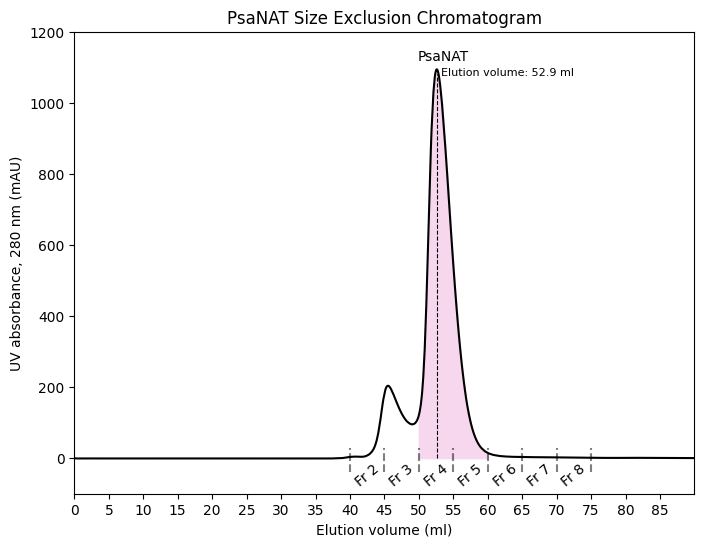

In [71]:
## import pandas as pd
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# Load the data into a pandas dataframe
df = pd.read_csv('../temp_files/PsaNAT_SEC.csv', delimiter='\t', comment='#', header=0)

# Subset the data from 40 mins onwards
# df = df[df.iloc[:, 0] >= 40]

# Subtract 40 mins from the x-axis
x = list(df.iloc[:, 0])
# x = [e -40 for e in x]
y = list(df.iloc[:, 1])
# Create a figure with black and white style
fig, ax = plt.subplots(figsize=(8, 6))
# Plot the data
ax.plot(x, y,color="black")

# Find the peaks and label them
peaks, _ = find_peaks(y, height=10)
print(x[peaks[4]])
# for i in range(len(peaks)):
#     ax.text(x[peaks[i]], y[peaks[i]], f"Peak {i+1}", ha='center', va='bottom')
# ax.plot(df.iloc[peaks,0], df.iloc[peaks,1], "x", label='Peak')

# Add labels and ticks
ax.set_xlabel('Elution volume (ml)')
ax.set_ylabel('UV absorbance, 280 nm (mAU)')
ax.set_xticks(np.arange(0, 90, 5))
ax.set_xticklabels(np.arange(0, 90, 5))
ax.set_xlim(0, 90)
ax.set_ylim(-100, 1200)
ax.set_title("PsaNAT Size Exclusion Chromatogram")
# Add fraction collection times
fraction_times = [42.5, 47.5, 52.5, 57.5, 62.5, 67.5, 72.5]
fraction_labels = ['Fr 2', 'Fr 3', 'Fr 4', 'Fr 5', 'Fr 6', 'Fr 7', 'Fr 8']
for i, time in enumerate(fraction_times):
    ax.text(time, -10, fraction_labels[i], rotation=40, fontsize=10, ha='center', va='top')
ax.vlines([52.595],0,1080,color="black",linewidth=0.8,linestyles="--")
ax.vlines([40, 45, 50, 55, 60, 65, 70, 75], -40, 30, color='black',linestyles="--",alpha=0.5)
# Set the background color to white

x_lower = 50
x_upper = 60
y_lower = 0
vals = [(x[i],y[i]) for i,i in enumerate(range(0,len(x))) if x[i] > x_lower and x[i] < x_upper]
x_grey = [d[0] for d in vals]
y_grey = [d[1] for d in vals]

# Shade the area between the limits with a light grey color
ax.fill_between(x_grey, y_lower, y_grey, color='#F6D7ED')

ax.text(13.5+40,1150,"PsaNAT",fontsize=10, ha="center", va = "top")
ax.text(13.2+40,1100,"Elution volume: 52.9 ml",fontsize=8, ha="left", va = "top")

# Adjust the zorder so that the shaded area is below the curve
ax.set_zorder(2)
ax.patch.set_zorder(1)
plt.rcParams['axes.facecolor'] = 'white'
plt.savefig('pretty_plot.png', dpi=300, bbox_inches='tight')
plt.show()


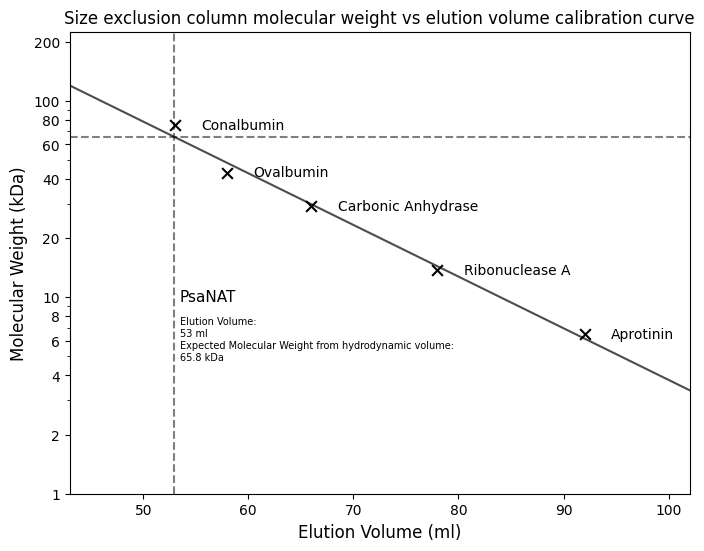

In [72]:
import matplotlib.pyplot as plt
import numpy as np
#[protein_name,mol_weight (Da),time (min)]
calibration_data = [
    ["Conalbumin",75000,53],
    ["Ovalbumin",43000,58],
    ["Carbonic Anhydrase", 29000, 66],
    ["Ribonuclease A",13700,78],
    ["Aprotinin",6512,92]
]
# extract the data for the x and y axis
mol_weights = [data[1] for data in calibration_data]
times = [data[2] for data in calibration_data]

# create the plot
plt.figure(figsize=(8, 6))
plt.scatter(times, mol_weights, s=60, marker='x', color='black')
plt.axvline(x=52.9, linestyle='--', color='black', alpha=0.5)
plt.ylabel('Molecular Weight (kDa)', fontsize=12)
plt.xlabel('Elution Volume (ml)', fontsize=12)
plt.xscale('linear')
plt.yscale('log')
plt.tick_params(labelsize=10)
plt.title("Size exclusion column molecular weight vs elution volume calibration curve")
# add protein names as text
for i in range(len(calibration_data)):
    plt.text(times[i]+2.5, mol_weights[i]*1.0, calibration_data[i][0], fontsize=10, ha='left', va='center', color='black')

plt.text(53.5, 8000, 'Elution Volume:\n53 ml', fontsize=7, ha='left', va='top')
plt.text(53.5, 10000, "PsaNAT", fontsize=11, ha='left', va='center', color='black')

# fit a trend line
coefficients = np.polyfit(times, np.log(mol_weights), 1)
polynomial = np.poly1d(coefficients)
x_axis = np.linspace(min(times)-10, max(times)+10, 100)
plt.plot(x_axis, np.exp(polynomial(x_axis)), color='black',alpha=0.7)

# add a line parallel to the x-axis at the estimated molecular weight
mol_weight_est = np.exp(polynomial(52.9))
plt.axhline(y=mol_weight_est, linestyle='--', color='black', alpha=0.5)
plt.text(53.5, 6000, f'Expected Molecular Weight from hydrodynamic volume:\n{mol_weight_est/1000:0.1f} kDa', fontsize=7, ha='left', va='top')

# set the axis limits
plt.xlim(min(times)-10, max(times)+10)
plt.ylim(min(mol_weights)*0.9, max(mol_weights)*3)

yticks = [1000,2000,4000,6000,8000,10000,20000,40000,60000,80000,100000,200000]
yticklabels = [f'{y/1000:.0f}' for y in yticks]
plt.yticks(yticks, yticklabels)
# set the background color to white
plt.rcParams['axes.facecolor'] = 'white'
plt.savefig('pretty_plot.png', dpi=300, bbox_inches='tight')
plt.show()


# Get sequences to compare both clades of E1 like proteins


In [4]:
import os
import glob
from Bio import SeqIO
from Bio.Seq import Seq
from tqdm.auto import tqdm
import pylev
import matplotlib.pyplot as plt
import numpy as np
import copy
from Bio import AlignIO
import random
from collections import Counter

def get_item_by_id(seqs, accession):
    for item in seqs:
        if item.id == accession.split(".")[0]:
            return item
    return None


In [ ]:
tridomain_filename_1 = "../processed_sequences/clustal_hmm_5_per_cluster_18022023/tridomain_1_sequences.txt"
tridomain_filename_2 = "../processed_sequences/clustal_hmm_5_per_cluster_18022023/tridomain_2_sequences.txt"
all_sequences_filename = "../processed_sequences/clustal_hmm_5_per_cluster_18022023/seqs7.txt"

output_tridomain_1_filename = "../processed_sequences/clustal_hmm_5_per_cluster_18022023/tridomain_1_sequences.fa"
output_tridomain_2_filename = "../processed_sequences/clustal_hmm_5_per_cluster_18022023/tridomain_2_sequences.fa"

all_sequences = [seq for seq in SeqIO.parse(all_sequences_filename,"fasta")]

tridomain_1_accessions = []
with open(tridomain_filename_1) as file:
    for line in file:
        tridomain_1_accessions.append(line.split("\n")[0])
tridomain_2_accessions = []
with open(tridomain_filename_2) as file:
    for line in file:
        tridomain_2_accessions.append(line.split("\n")[0])    


random.shuffle(tridomain_1_accessions)
random.shuffle(tridomain_2_accessions)

tridomain_1_sequences = []
for accession in tridomain_1_accessions[:100]:
    seq = get_item_by_id(all_sequences,accession)
    seq.id = "Tri1_"+seq.id
    if(type(seq) == None):
        raise Exception("Accession not found in sequences, something must have gone wrong...")
    tridomain_1_sequences.append(seq)
    
tridomain_2_sequences = []
for accession in tridomain_2_accessions[:100]:
    seq = get_item_by_id(all_sequences,accession)
    if(type(seq) == None):
        raise Exception("Accession not found in sequences, something must have gone wrong...")
    tridomain_1_sequences.append(seq)

SeqIO.write(tridomain_1_sequences, output_tridomain_1_filename, "fasta")
# SeqIO.write(tridomain_2_sequences, output_tridomain_2_filename, "fasta")


## Run clustalo on the outputed sequences in terminal

In [23]:
# aligned_sequences_filename = "../processed_sequences/clustal_hmm_5_per_cluster_18022023/tridomain_alignment_test.fa"
all_aligned_sequences = AlignIO.read(aligned_sequences_filename, "clustal")
AlignIO.write(all_aligned_sequences, aligned_sequences_filename+".fa", "fasta")
tridomain_1_alignment_sequences = []
tridomain_2_alignment_sequences = []

lynD_seq = copy.deepcopy(all_aligned_sequences[0])
for seq in all_aligned_sequences:
    if "Tri1" in seq.id:
        tridomain_1_alignment_sequences.append(seq)
    else:
        tridomain_2_alignment_sequences.append(seq)
        
tridomain_1_occupancy = []
tridomain_2_occupancy = []
for res_pos in range(0,len(all_aligned_sequences[0].seq)):
    tridomain_1_occupancy.append(0)
    for seq in tridomain_1_alignment_sequences:
        if(seq.seq[res_pos] != "-"):
            tridomain_1_occupancy[-1] += 1
            
    tridomain_2_occupancy.append(0)
    for seq in tridomain_2_alignment_sequences:
        if(seq.seq[res_pos] != "-"):
            tridomain_2_occupancy[-1] += 1

def seq_pos(pos):
    return 405+pos-lynD_seq.seq[:pos].count("-")+1

n = len(lynD_seq.seq)
tridomain_1_char_counts = [Counter() for _ in range(n)]
for sequence in tridomain_1_alignment_sequences:
    for i, char in enumerate(sequence.seq):
        tridomain_1_char_counts[i][char] += 1
        
tridomain_2_char_counts = [Counter() for _ in range(n)]
for sequence in tridomain_2_alignment_sequences:
    for i, char in enumerate(sequence.seq):
        tridomain_2_char_counts[i][char] += 1
        
relevant_positions = []
for i in range(n):
    counts_1 = tridomain_1_char_counts[i].most_common()
    most_common_char_1 = counts_1[0][0]
    percentage_char_1 = counts_1[0][1]/sum(tridomain_1_char_counts[i].values())
    
    counts_2 = tridomain_2_char_counts[i].most_common()
    most_common_char_2 = counts_2[0][0]
    percentage_char_2 = counts_2[0][1]/sum(tridomain_2_char_counts[i].values())
    if(percentage_char_1 > 0.8 and most_common_char_1 != "-"):
        print(f"Consensus at position {i},{seq_pos(i)}, {percentage_char_1*100}% residue {most_common_char_1}")
        relevant_positions.append(i)

        if(most_common_char_2 != most_common_char_1):
            print(f"DIFF, {most_common_char_2}, {percentage_char_2*100}%")
# tridomain_1_occupancy = [x/len(tridomain_1_alignment_sequences) for x in tridomain_1_occupancy]
# tridomain_2_occupancy = [x/len(tridomain_2_alignment_sequences) for x in tridomain_2_occupancy]
# for res_pos in range(0,len(all_aligned_sequences[0].seq)):
#     tri1_occupied = (tridomain_1_occupancy[res_pos] > 0.7)
#     tri2_empty = (tridomain_2_occupancy[res_pos] < 0.3)
#     if(tri1_occupied & tri2_empty):
#         relevant_positions.append(res_pos)
        
lynD_positions = []
for relevant_position in relevant_positions:
    lynD_positions.append(405+relevant_position-lynD_seq.seq[:relevant_position].count("-")+1)
print(f"select #1/A:{','.join([str(x) for x in lynD_positions])}")


Consensus at position 63,408, 100.0% residue G
Consensus at position 64,409, 100.0% residue K
DIFF, R, 65.0%
Consensus at position 65,410, 100.0% residue G
DIFF, T, 45.0%
Consensus at position 67,412, 83.16831683168317% residue T
DIFF, S, 67.0%
Consensus at position 77,422, 80.19801980198021% residue C
DIFF, L, 89.0%
Consensus at position 78,423, 100.0% residue E
Consensus at position 79,424, 95.04950495049505% residue A
DIFF, G, 85.0%
Consensus at position 81,426, 100.0% residue E
Consensus at position 82,427, 99.00990099009901% residue R
Consensus at position 84,429, 83.16831683168317% residue S
DIFF, C, 50.0%
Consensus at position 90,434, 98.01980198019803% residue G
Consensus at position 91,435, 84.15841584158416% residue D
DIFF, K, 65.0%
Consensus at position 92,436, 98.01980198019803% residue E
DIFF, R, 67.0%
Consensus at position 102,446, 80.19801980198021% residue L
Consensus at position 116,450, 82.17821782178217% residue A
Consensus at position 118,452, 84.15841584158416% res

In [ ]:
percentage_identities = []
for sequence in tridomain_2_alignment_sequences:
    